Predictive maintenance allows early detection of failures based on historical data. This type of maintenance reduces unscheduled maintenance costs and incresases the lifespan of a machine. Generally 3 types of approaches exist in literature:
1. Using Life Time Data: Failures are anticipated before they occurs thanks to proportional hazard models and probability distributions of component failure times
2. Run-to-Failure Data: If run-to-failure data of many machines exists, then health state of a particular machine can be estimated by comparing the others.
3. Threshold Data: When historical or failure data does not exist, a degredation model can be created and failure time can be estimated with a threshold value.

In this work 'threshold data' approach is utilized because limited amount of run-to-failure data exist. Also bearings' features are suitable to create a degredation model. 


In [1]:
#importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit


# Merging Data

In [2]:
#Data paths
dataset_path_1st = r'D:\Downloads2\IMS\IMS\1st_test\1st_test'
dataset_path_2nd = r'D:\Downloads2\IMS\IMS\2nd_test'
dataset_path_3rd = r'D:\Downloads2\IMS\IMS\3rd_test\4th_test\txt'

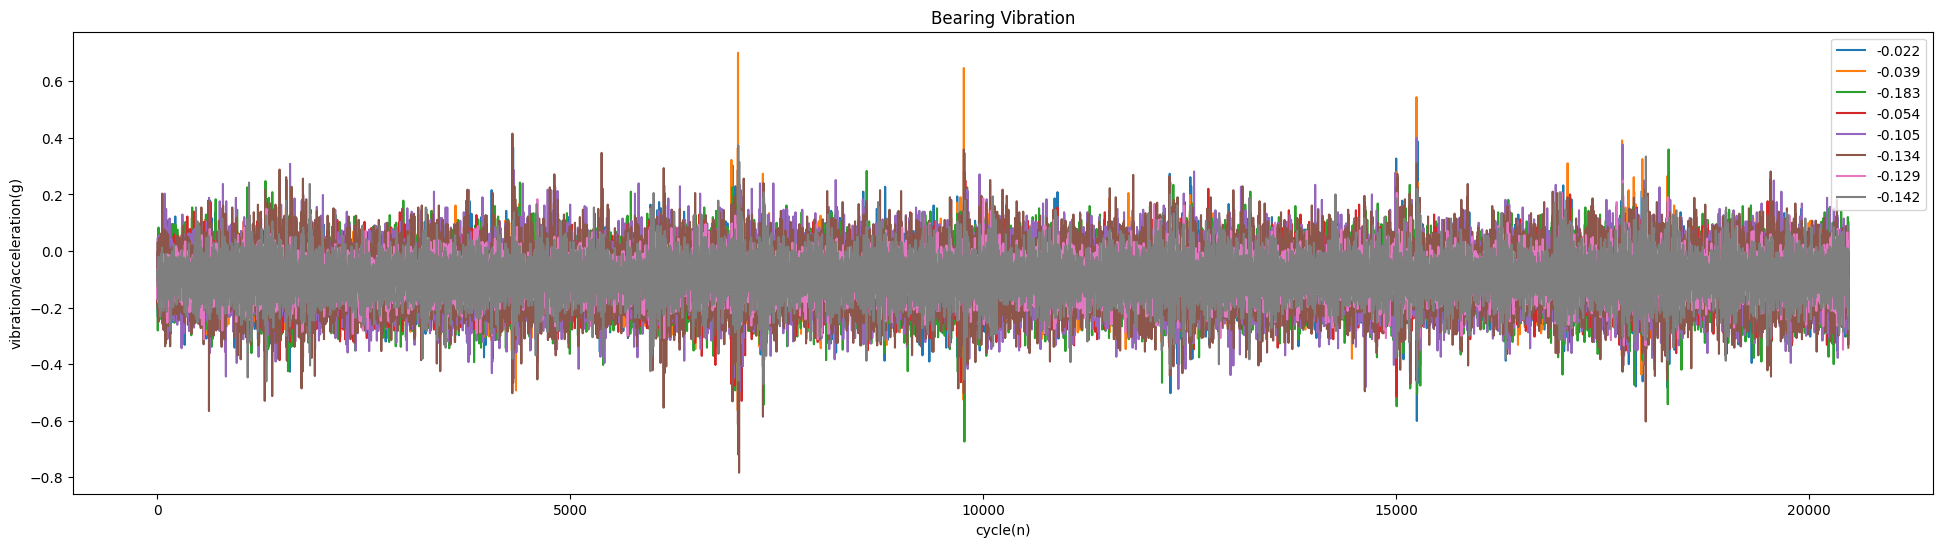

In [3]:
# Test for the first file
dataset = pd.read_csv(r'D:\Downloads2\IMS\IMS\1st_test\1st_test\2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Feature Extraction #

In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$


In [4]:
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)

        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = pd.concat([data, merge], ignore_index=False, sort=False)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data                                  

1.  Calling feature extraction function defined above to merge extracted features      
2.  Saving as .csv file

In [5]:
# Check if the file already exists
if os.path.isfile('set1_timefeatures.csv'):
    print("Loading existing set1_timefeatures.csv file...")
    set1 = pd.read_csv("./set1_timefeatures.csv")
    set1 = set1.rename(columns={'Unnamed: 0':'time'})
else:
    print("Extracting features for set1 (this may take a while)...")
    set1 = time_features(dataset_path_1st, id_set=1)
    set1.to_csv('set1_timefeatures.csv')
    print("Features extracted and saved to set1_timefeatures.csv")
    set1 = pd.read_csv("./set1_timefeatures.csv")
    set1 = set1.rename(columns={'Unnamed: 0':'time'})

last_cycle = int(len(set1))

Loading existing set1_timefeatures.csv file...


Reading Data again

In [6]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set1 = set1.rename(columns={'Unnamed: 0':'time'})
#set1 = set1.set_index('time')
last_cycle = int(len(set1))

In [7]:
# Load RUL dataset and compute Remaining Useful Life (RUL)
import pandas as pd
df_rul = pd.read_csv('set1_timefeatures.csv').rename(columns={'Unnamed: 0':'time'})
df_rul['cycle'] = pd.RangeIndex(start=0, stop=len(df_rul), step=1)
df_rul['time_to_failure'] = df_rul['cycle'].max() - df_rul['cycle']
df_rul = df_rul.drop(columns=['time'])

Moving average filter (also known as rolling average, running average) is a time series filter which calculates running weighted sum of time series. Simple moving average, cumulative moving average ,and exponantiel moving average methods are applied to feature data for smoothing. After comparing the results on a graph, it is concluded that EMA(40) is best option for filtering because it best reflecting the actual moves of the real data.

In [8]:
features = set1.copy()
#simple moving average SMA
ma = pd.DataFrame()
ma['B4_x_mean'] = features['B4_x_mean']
ma['SMA'] = ma['B4_x_mean'].rolling(window=5).mean()
ma['time'] = features['time']

In [9]:
#Cumulative Moving Average
ma['CMA'] = ma["B4_x_mean"].expanding(min_periods=10).mean()

In [10]:
#Exponantial Moving Average
ma['EMA'] = ma['B4_x_mean'].ewm(span=40,adjust=False).mean()

<Axes: xlabel='time'>

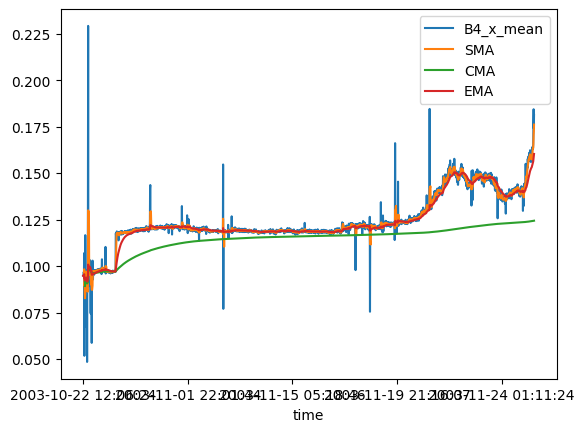

In [11]:
ma.plot(x="time", y= ['B4_x_mean','SMA','CMA','EMA'])

* **PCA**

In order to build a degredation model, a feature that represents the information of base features is extracted using Principal Component Analysis. The principal component that have highest variance is selected and further investigations are conducted on that component. Dimensionalty of redunduncy of the data is reduced and a principle feature is obtained.

* **Model Fitting**

In the time series prediction, it is assumed that degredations occurs exponantially in many natural phenomena, such as decay of a aradioactive element. Therefore, an exponantial model which have always positive slope is created as a function and it is fitted with scipy.optimize library. In order not to miss the specific movement that may help to forecast the future, exponential model is not fitted to whole data that is available. Instead, exponential function is fitted to last n data.

# RUL Prediction

In [12]:
def health_indicator(bearing_data,use_filter=False):    
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)
    
    return degredation

def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(degredation.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq
log = [[],[]]

The first 550 cycle is assumed to be healthy

In [13]:
#variable for incrementing index
prediction_cycle = 600
#variable for keeping intial value
init_cycle = prediction_cycle

In [14]:
#selected_features = ['mean','std','kurtosis','skew','entropy',
#        'rms','max','p2p','crest','shape','impulse']
selected_features = ['max','p2p','rms']

bearing = 3
B_x = ["B{}_x_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_x][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9955862512721907


Explained variance of Pricincipal Component 1 is:0.9955862512721907
0.29968710671878446 0.000457257352356167
failed at4151.192970410757


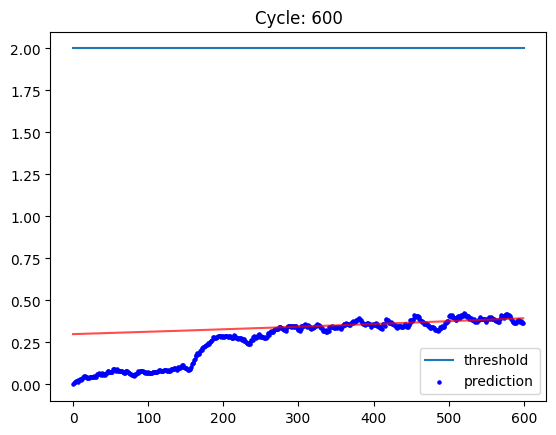

In [15]:
#run this again, again to simulate life-cycle of a bearing
data = set1[B_x][:prediction_cycle]
ind=data.index
degredation = health_indicator(data,use_filter=True)
#degredation.plot(y='PC1',x='cycle')
fit = fit_exp(degredation,base=250)

prediction = predict(degredation,fit)
m,n = fit[0]
thres = 2
#print(prediction_cycle)
fail_cycle = (np.log(thres/m))/abs(n)
log[0].append(prediction_cycle)
log[1].append(fail_cycle)

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()


ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()
increment_cycle =25
prediction_cycle += increment_cycle


**Life Cycle of Bearing 3 in data set1 with prediction curve**

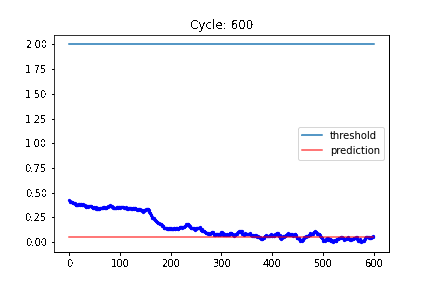

In [16]:
# Truncate log arrays to match time_sliced length
time_sliced = set1['time'][init_cycle::increment_cycle]
log_length = min(len(time_sliced), len(log[0]))

# Create the DataFrame with truncated arrays
d = {
    'time': time_sliced[:log_length], 
    'cycle': log[0][:log_length], 
    'prediction': np.array(log[1][:log_length])
}
df = pd.DataFrame(data=d)

# Add isvalid column based on the condition
df['isvalid'] = df['prediction'] < 2156

# Adding real labels for analyzing results
df['real'] = np.zeros(len(df), dtype=object)  # ✅ MATCH length to df, not time_sliced

for idx in df.index:  # ✅ Loop through df.index, not time_sliced.index
    if bearing == 1:
        if idx <= 151:
            df.at[idx, 'real'] = 'early'
        elif 151 < idx <= 600:
            df.at[idx, 'real'] = 'suspect'
        elif 600 < idx <= 1499:
            df.at[idx, 'real'] = 'normal'
        elif 1499 < idx <= 2098:
            df.at[idx, 'real'] = 'suspect'
        elif 2098 < idx <= 2156:
            df.at[idx, 'real'] = 'imminent_failure'
    elif bearing == 2:
        if idx <= 500:
            df.at[idx, 'real'] = 'early'
        elif 500 < idx <= 2000:
            df.at[idx, 'real'] = 'normal'
        elif 2000 < idx <= 2120:
            df.at[idx, 'real'] = 'suspect'
        elif 2120 < idx <= 2156:
            df.at[idx, 'real'] = 'imminent_failure'
    elif bearing == 3:
        if idx <= 500:
            df.at[idx, 'real'] = 'early'
        elif 500 < idx <= 1790:
            df.at[idx, 'real'] = 'normal'
        elif 1790 < idx <= 2120:
            df.at[idx, 'real'] = 'suspect'
        elif 2120 < idx <= 2156:
            df.at[idx, 'real'] = 'Inner_race_failure'
    elif bearing == 4:
        if idx <= 200:
            df.at[idx, 'real'] = 'early'
        elif 200 < idx <= 1000:
            df.at[idx, 'real'] = 'normal'
        elif 1000 < idx <= 1435:
            df.at[idx, 'real'] = 'suspect'
        elif 1435 < idx <= 1840:
            df.at[idx, 'real'] = 'Inner_race_failure'
        elif 1840 < idx <= 2156:
            df.at[idx, 'real'] = 'Stage_two_failure'

# Print the bearing and the last 60 rows of the DataFrame for checking
print(bearing)
print(df.tail(60))


3
                    time  cycle  prediction  isvalid    real
600  2003-11-08 12:21:44    600  4151.19297    False  normal


According to the dataset description, at the end of the test-to-failure experiment, inner race defect occurred in
bearing 3 and roller element defect in bearing 4.

# Reference
1. https://www.mathworks.com/help/predmaint/ug/wind-turbine-high-speed-bearing-prognosis.html
2. https://www.mathworks.com/company/newsletters/articles/three-ways-to-estimate-remaining-useful-life-for-predictive-maintenance.html
3. http://emilygraceripka.com/blog/14
4. https://acadpubl.eu/hub/2018-119-15/4/745.pdf
5. https://www.kaggle.com/ryanholbrook/principal-component-analysis
6. https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis

# Additional Resources
1. https://arxiv.org/pdf/1812.03315.pdf


### PyTorch-based RUL Prediction
Use a PyTorch LSTM to predict Remaining Useful Life (RUL).

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [18]:
# Prepare sequence data helper (unchanged)
def create_sequences(df, seq_length=50, target_col='time_to_failure'):
    data = df.values
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # all features except target
        y.append(data[i+seq_length-1, -1])  # target is last column
    return np.array(X), np.array(y)

In [19]:
# Scale and split data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# df_rul must contain features + 'time_to_failure' column
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_rul)
X, y = create_sequences(pd.DataFrame(data_scaled, columns=df_rul.columns), seq_length=50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).float().unsqueeze(-1)
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [20]:
# Define LSTM model
class RULLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
# Instantiate, optimizer, loss
model = RULLSTM(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

In [21]:
# Training loop
epochs = 20
model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    print(f'\nEpoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


Epoch 1/20, Loss: 0.0084

Epoch 2/20, Loss: 0.0014

Epoch 3/20, Loss: 0.0020

Epoch 4/20, Loss: 0.0008

Epoch 5/20, Loss: 0.0011

Epoch 6/20, Loss: 0.0004

Epoch 7/20, Loss: 0.0011

Epoch 8/20, Loss: 0.0011

Epoch 9/20, Loss: 0.0004

Epoch 10/20, Loss: 0.0006

Epoch 11/20, Loss: 0.0012

Epoch 12/20, Loss: 0.0003

Epoch 13/20, Loss: 0.0004

Epoch 14/20, Loss: 0.0004

Epoch 15/20, Loss: 0.0004

Epoch 16/20, Loss: 0.0005

Epoch 17/20, Loss: 0.0003

Epoch 18/20, Loss: 0.0006

Epoch 19/20, Loss: 0.0002

Epoch 20/20, Loss: 0.0002


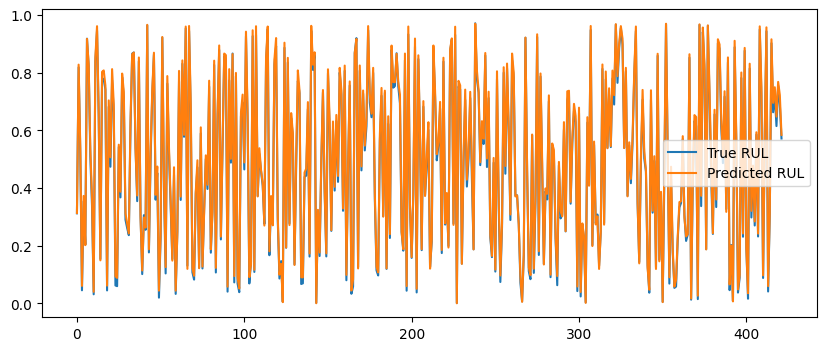

In [22]:
# Evaluation and plotting
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
true   = y_test.numpy().flatten()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(true, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.legend()
plt.show()

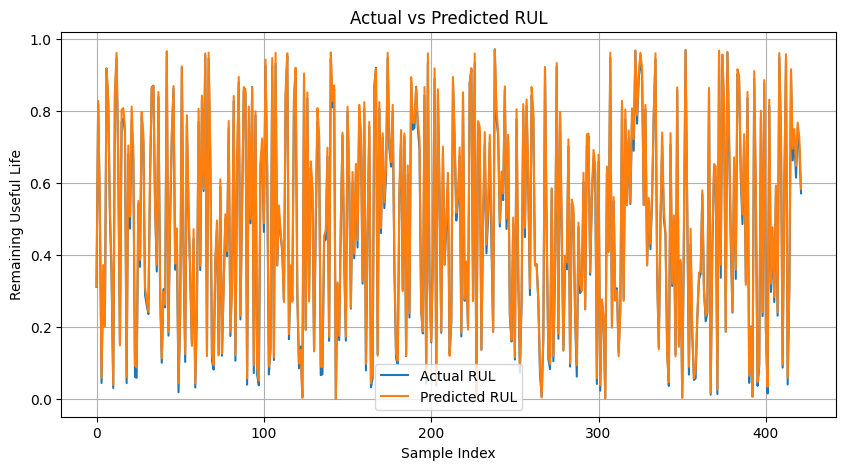

In [23]:
# Plot Actual vs Predicted RUL
import matplotlib.pyplot as plt
# y_test and y_pred must be defined from previous cells
plt.figure(figsize=(10,5))
plt.plot(y_test.numpy().flatten(), label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()